In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [16]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.point_clouds.gan import model_saver_id
from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.raw_wgan import RawWGAN

from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, point_cloud_distances, jensen_shannon_divergence

from tf_lab.nips.helper import pclouds_centered_and_half_sphere

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
n_pc_samples = 2048
do_training = True
do_plotting = True
save_model = True
save_synthetic_samples = True
seed = 42
voxel_resolution = 32

class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/'
experiment_name = 'raw_gan_' + class_name +'_' + str(n_pc_samples) +  '_pts'

Give me the class type.
chair


In [6]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/raw_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,
                                                                           n_threads=25, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )
train_data = PointCloudDataSet(full_pclouds)

# gt_m_entropy, gt_voxel_rv = entropy_of_occupancy_grid(full_pclouds, voxel_resolution)
# print gt_m_entropy

6778 files containing complete point clouds were found.


In [11]:
init_lr = 0.0005
max_epochs = 500
batch_size = 50
noise_params = {'mu':0, 'sigma': 1}

n_syn_samples = train_data.num_examples  # Same number as original GT data.
accum_syn_data = []
train_stats = []

reset_tf_graph()
gan = RawGAN(experiment_name, learning_rate=init_lr, n_output=[n_pc_samples, 3])

In [12]:
# if do_training:
#     for _ in range(max_epochs):
#         checkpoint_path = osp.join(train_dir, model_saver_id)
#         loss, duration = gan._single_epoch_train(train_data, batch_size, noise_params)
#         epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
#         print epoch, loss, duration
#         if save_model:
#             gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
#         train_stats.append((epoch,) + loss)
#         accum_syn_data.append(gan.generate(n_syn_samples, noise_params))

1 (1.1580923305617439, 1.0880526586815162) 27.8129298687
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/raw_gan/raw_gan_chair_2048_pts/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
2 (1.2870193560918173, 0.91691625868832627) 27.7584722042
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/raw_gan/raw_gan_chair_2048_pts/models.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.
3 (1.2573198508333276, 1.0463822875861768) 27.887609005
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/raw_gan/raw_gan_chair_2048_pts/models.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.
4 (1.1610894812477959, 1.2833313917672193) 28.1025948524
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/raw_gan/raw_gan_chair_2048_pts/models.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.
5 (1.0976782304269297, 1.47106982911

KeyboardInterrupt: 

[array([[[ 0.05019012, -0.03644796,  0.01878279],
         [ 0.11143585, -0.0851856 , -0.02302726],
         [ 0.11924882,  0.05845649, -0.03335581],
         ..., 
         [ 0.08255368, -0.00904311, -0.03244374],
         [ 0.0745804 ,  0.07361729, -0.03437783],
         [-0.07664433, -0.05616978, -0.02507647]],
 
        [[ 0.07717528,  0.02734848, -0.02865453],
         [ 0.05356987, -0.07562651, -0.02923378],
         [ 0.06644858,  0.02917497, -0.07045528],
         ..., 
         [ 0.08275397,  0.01073749, -0.06438266],
         [ 0.06885258,  0.04815032, -0.06948282],
         [-0.05869062, -0.06826375, -0.03207782]],
 
        [[ 0.07532327, -0.00256418, -0.01328838],
         [ 0.00402696, -0.10502736, -0.02401312],
         [ 0.09853148,  0.0852996 , -0.02793642],
         ..., 
         [ 0.05599815, -0.05855778, -0.03155357],
         [ 0.0770522 ,  0.05060798, -0.06753549],
         [-0.07127637, -0.0902042 , -0.07860638]],
 
        ..., 
        [[ 0.0560895 , -0.029814

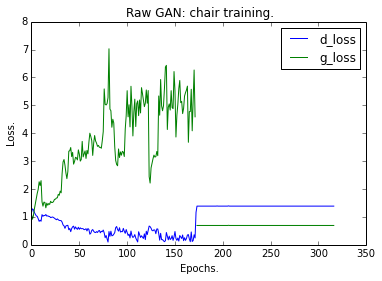

In [13]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss)
    plt.plot(x, g_loss)
    plt.title('Raw GAN: %s training.' %(class_name,))
    plt.legend(['d_loss', 'g_loss'], loc=0)
    plt.xlabel('Epochs.')
    plt.ylabel('Loss.')

In [ ]:
grad_blown = np.where(np.array(g_loss) == np.inf)[0][0]
ok_syn_data =np.array(accum_syn_data[:grad_blown])

In [14]:
jsd = []
emd_dists = []

for sdata in ok_syn_data:

    
    
    
    
    for i, pc in enumerate(sdata_r): # in u sphere
        sdata_r[i] = Point_Cloud(pc).center_in_unit_sphere().points        
    _, s_var = entropy_of_occupancy_grid(sdata_r, voxel_resolution)
    jsd.append(jensen_shannon_divergence(gt_voxel_rv,  s_var))
    emd_dists.append(point_cloud_distances(sdata_r, 10, gan.sess, 'emd'))
mean_emd_dists = [np.mean(i) for i in emd_dists]

In [ ]:
epoch_to_check = 30
check_data = accum_syn_data[epoch_to_check]
save_out = osp.join(synthetic_data_out_dir, 'v0_' + experiment_name + '_epoch_' + str(epoch_to_check))
np.savez(save_out, check_data)

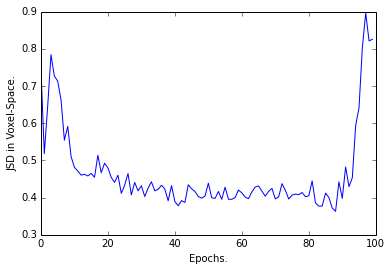

In [16]:
plt.plot(range(len(jsd)), jsd)
plt.xlabel('Epochs.')
plt.ylabel('JSD in Voxel-Space.')

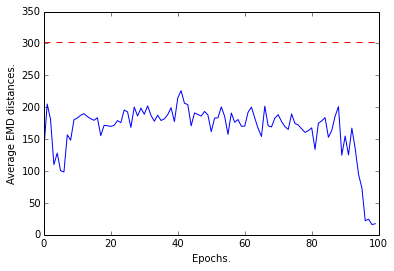

In [17]:
plt.xlabel('Epochs.')
plt.ylabel('Average EMD distances.')
plt.plot(range(len(mean_emd_dists)), mean_emd_dists)
plt.plot(range(len(mean_emd_dists)), np.ones(len(mean_emd_dists)) * 302.4, '--r' )

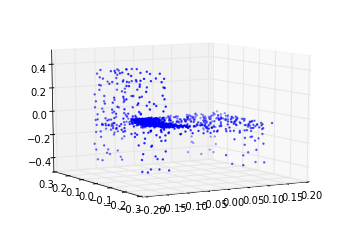

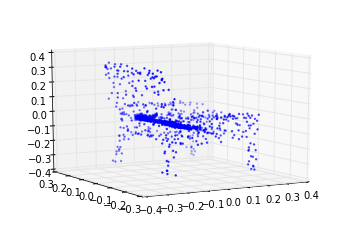

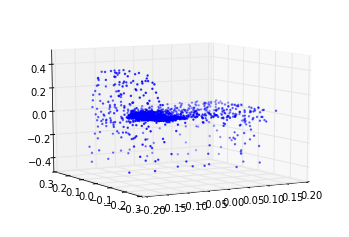

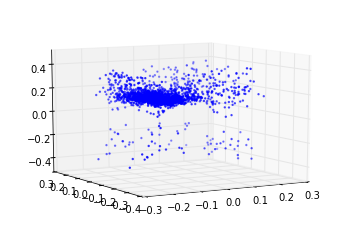

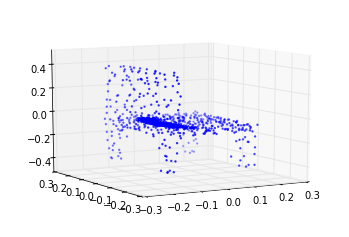

In [42]:
epoch_to_check = 40
check_data = accum_syn_data[epoch_to_check]
rids = np.random.choice(range(len(check_data)), size=5, replace=False)

for i in range(5):
    Point_Cloud(check_data[rids[i]]).plot()
    
save_out = osp.join(synthetic_data_out_dir, experiment_name + '_epoch_' + str(epoch_to_check))
np.savez(save_out, check_data)


In [41]:
save_out

'/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/raw_gan_chair_2048_pts_epoch_40'

In [ ]:
# First put in u-sphere then save.
if save_synthetic_samples:
    for i, pc in enumerate(syn_data):        
        pc = Point_Cloud(syn_data_rot[i]).center_in_unit_sphere()
        syn_data_rot[i] = pc.points
        
    save_out = osp.join(synthetic_data_out_dir, experiment_name + '_epoch_' + str(epoch))
    np.savez(save_out, syn_data_rot)

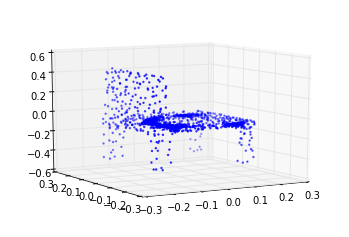

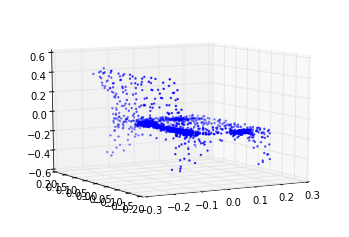

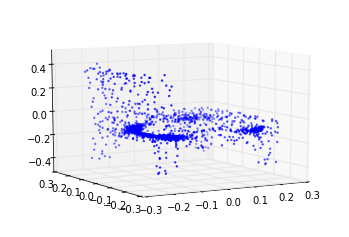

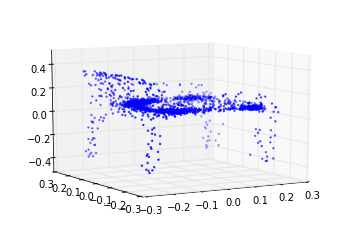

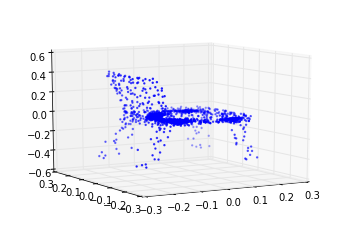

In [39]:
for i in range(5):
    Point_Cloud(gan.generate(1, noise_params)[0]).plot()